In [4]:
# %load_ext is safe to repeatedly run in a Jupyter notebook; it will just ignore duplicates.
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch
from torch import Tensor, nn, optim 

# Force reload of physics module
import importlib
import sys
if 'physics' in sys.modules:
    import physics
    importlib.reload(physics)
    
from physics import ho_variational_loss
from model import MLP

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Part 1 - Training the Model

### 1️⃣ Hyperparameters and Configuration

In [6]:
# ============================================================================
# 🎛️ CONFIGURATION PARAMETERS
# ============================================================================

# Training hyperparameters
lr              = 1e-3      # Learning rate
epochs          = 6_000     # Number of training epochs
n_points        = 64        # Number of collocation points
log_every       = 400       # Print loss every N epochs

# Physics parameters
omega           = 1.0       # Natural frequency of oscillator

# ============================================================================

torch.manual_seed(0)

# 1. Build the network
model: nn.Module = MLP(hidden=64, device=device) 
model.to(device)
model.eval()        # inference mode (no dropout/BN), BUT gradients on

# 2. Create collocation points in [0, 2 * torch.pi]
t_collocation: Tensor = 2 * torch.pi * torch.rand(n_points, 1, device=device)

# 3. Compute the physics-informed loss
initial_loss = ho_variational_loss(model, t_collocation, omega=omega)
print(f"Initial variational loss: {initial_loss.item():.6f}")

Initial variational loss: 1.233754


### 2️⃣ Training loop

In [7]:
# Increase points for better coverage of the larger window
n_points = 256

optimizer = optim.Adam(model.parameters(), lr=lr)
loss_history = []

for epoch in range(1, epochs + 1):
    optimizer.zero_grad()
    loss = ho_variational_loss(model, t_collocation, omega=omega)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % log_every == 0 or epoch == 1:
        print(f"epoch {epoch:4d} | loss = {loss.item():.6e}")

epoch    1 | loss = 1.233754e+00
epoch  400 | loss = 4.796765e-05
epoch  800 | loss = 1.436062e-05
epoch 1200 | loss = 4.433021e-06
epoch 1600 | loss = 1.482306e-06
epoch 2000 | loss = 2.926633e-04
epoch 2400 | loss = 7.216148e-07
epoch 2800 | loss = 1.851983e-07
epoch 3200 | loss = 1.273646e-07
epoch 3600 | loss = 8.223924e-08
epoch 4000 | loss = 3.909030e-04
epoch 4400 | loss = 9.540204e-08
epoch 4800 | loss = 5.713953e-08
epoch 5200 | loss = 5.110096e-08
epoch 5600 | loss = 4.525625e-07
epoch 6000 | loss = 1.272938e-07


### 3️⃣ Loss curve

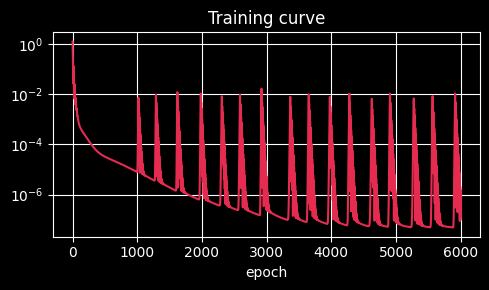

In [8]:
plt.figure(figsize=(5, 3))
plt.plot(loss_history, linewidth=1.5, color="#E52B50")
plt.yscale("log")
plt.xlabel("epoch")
plt.title("Training curve")
plt.grid(True)
plt.tight_layout()
plt.savefig("../artifacts/training.png", dpi=200)
plt.show()

### 4️⃣ Compare network vs. analytic solution

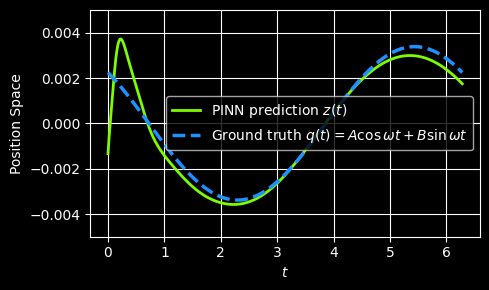

In [9]:
# Dense grid for visualization (extend to 2*T_max to see behavior beyond training window)
t_dense = torch.linspace(0, 2 * torch.pi, 1000, device=device).view(-1, 1)
with torch.no_grad():
    x_pred = model(t_dense).cpu().squeeze()

# Fit the two unknown constants (A, B) of the analytic solution
# x(t) = A * cos(omega*t) + B * sin(omega*t) using least squares.
t_np = t_dense.cpu().numpy()
W    = np.column_stack([np.cos(omega * t_np), np.sin(omega * t_np)])
A_B, *_ = np.linalg.lstsq(W, x_pred.numpy(), rcond=None)    # [A, B]

x_exact = torch.tensor(W @ A_B, dtype=x_pred.dtype)

# Plot results
plt.figure(figsize=(5, 3))
plt.plot(t_dense.cpu(), x_pred,  label=r"PINN prediction $z(t)$", color="#7CFC00", lw=2)
plt.plot(t_dense.cpu(), x_exact, label=r"Ground truth $q(t)= A\cos\omega t+B\sin\omega t$", ls="--", color="#1E90FF", lw=2.5)
plt.xlabel(r"$t$")
plt.ylabel("Position Space")
plt.ylim(-0.005,0.005)
plt.legend(loc='best')
plt.tight_layout()
plt.grid(True)
plt.savefig("../artifacts/trajectory.png", dpi=200)
plt.show()

## Part 2 - Model Evaluation

### 1️⃣ Construct Phase Space Grid

In [10]:
# Time grid for model evaluation (use T_max from config)
t = torch.linspace(0, 2 * torch.pi, 400).view(-1, 1)
t.requires_grad_(True)

# Forward pass
x = model(t)

# First derivative: dx/dt = p(t)
dx = torch.autograd.grad(
    x,
    t,
    grad_outputs=torch.ones_like(x),
    create_graph=True,
)[0]

# Phase space grid for model evaluation (NOT collocation points)
x_np = x.detach().cpu().numpy().flatten()
p_np = dx.detach().cpu().numpy().flatten()
t_np = t.detach().cpu().numpy().flatten()

### 2️⃣ Energy Curve

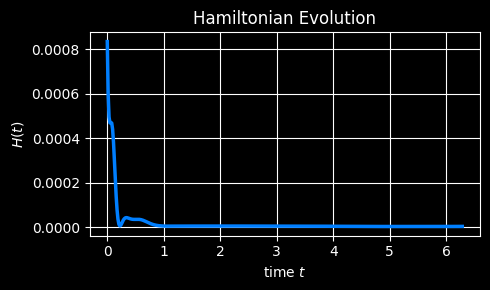

In [11]:
# Hamiltonian H(t)
H = 0.5 * p_np**2 + 0.5 * omega**2 * x_np**2

# Plot Hamiltonian
plt.figure(figsize=(5, 3))
plt.plot(t_np, H, color="#007FFF",lw=2.5)
plt.xlabel(r"time $t$")
plt.ylabel(r"$H(t)$")
plt.title("Hamiltonian Evolution")
plt.tight_layout()
plt.grid(True)
plt.savefig("../artifacts/energy.png", dpi=200)
plt.show()



### 3️⃣ Hamiltonian Flow Field and Vector Field with Learned Phase Trajectory

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


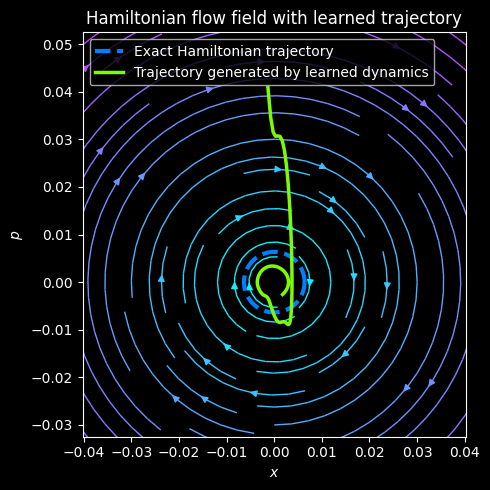

In [12]:
X, P = np.meshgrid(
    np.linspace(-0.06, 0.06, 20),
    np.linspace(-0.06, 0.06, 20),
)

U = P
V = -omega**2 * X          # assume omega is defined elsewhere

speed = np.sqrt(U**2 + V**2)

plt.figure(figsize=(5, 5))

# --- Hamiltonian flow (background) ---
strm = plt.streamplot(
    X, P, U, V,
    color=speed,
    cmap="cool",
    density=1.1,
    arrowsize=1,
    linewidth=1.0,
)
#cbar = plt.colorbar(strm.lines, label="Gradient magnitude")
#cbar.set_ticks([])

# --- Extract Hamiltonian trajectory (reference) ---
H0 = np.mean(0.5 * p_np**2 + 0.5 * omega**2 * x_np**2)
theta = np.linspace(0, 2*np.pi, 400)
r = np.sqrt(2 * H0)

plt.plot(
    r*np.cos(theta)/omega,
    r*np.sin(theta),
    ls="--",
    color="#007FFF",
    lw=3,
    label="Exact Hamiltonian trajectory"
)

# --- PINN trajectory ---
plt.plot(
    x_np,
    p_np,
    color="#7CFC00",
    lw=2.5,
    label="Trajectory generated by learned dynamics"
)

# --- Labels & layout
plt.xlabel(r"$x$")
plt.ylabel(r"$p$")

plt.title("Hamiltonian flow field with learned trajectory")

plt.legend(frameon=True)
plt.axis("equal")
plt.xlim(-0.03, 0.03)
plt.ylim(-0.03, 0.05)

plt.tight_layout()
plt.savefig("../artifacts/phase_space.png", dpi=200)
plt.show()

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


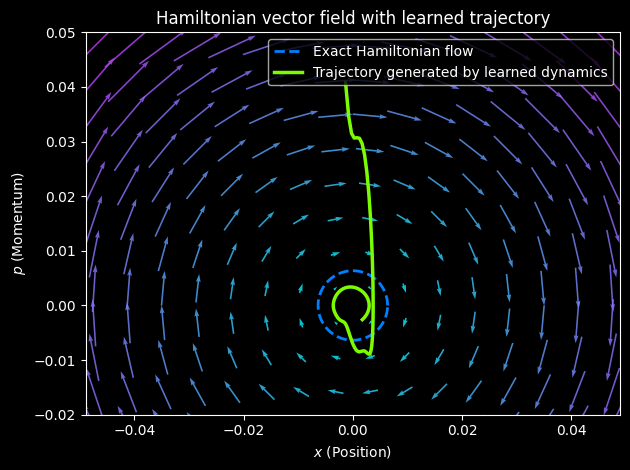

In [13]:
# 1. Setup the grid for the vector field
U = P
V = -omega**2 * X
speed = np.sqrt(U**2 + V**2)

# 3. Plot the Vector Field (Quiver)
# 'pivot'='mid' centers the arrows on the grid points
q = plt.quiver(X, P, U, V, speed,
              cmap="cool",
              alpha=0.8,
              pivot='mid',
              units='inches',
              scale=0.1)

# 4. Plot Exact Hamiltonian Orbit (Reference)
H0 = np.mean(0.5 * p_np**2 + 0.5 * omega**2 * x_np**2)
theta_grid = np.linspace(0, 2*np.pi, 400)
r_orbit = np.sqrt(2 * H0)

# --- Extract Hamiltonian trajectory (reference) ---
H0 = np.mean(0.5 * p_np**2 + 0.5 * omega**2 * x_np**2)
theta = np.linspace(0, 2*np.pi, 400)
r = np.sqrt(2 * H0)

plt.plot(
    r*np.cos(theta)/omega,
    r*np.sin(theta),
    ls="--",
    color="#007FFF",
    lw=2,
    label="Exact Hamiltonian flow"
)

# --- PINN trajectory ---
plt.plot(
    x_np,
    p_np,
    color="#7CFC00",
    lw=2.5,
    label="Trajectory generated by learned dynamics"
)

# 6. Final Formatting
plt.xlabel(r"$x$ (Position)")
plt.ylabel(r"$p$ (Momentum)")
plt.title("Hamiltonian vector field with learned trajectory")
plt.legend(frameon=True, loc='upper right')
plt.axis("equal")

# Set limits based on your existing scale
plt.xlim(-0.035, 0.035)
plt.ylim(-0.02, 0.05)

plt.tight_layout()
plt.savefig("../artifacts/phase_space_quiver.png", dpi=200)
plt.show()